# Imports

In [2]:
import os
import json
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import re

# Machine Learning Results

In [3]:
BASE_DIR = "results"
records = []
for root, dirs, files in os.walk(BASE_DIR):
    if "accuracy_report.json" in files:
        json_path = os.path.join(root, "accuracy_report.json")
        
        # Load JSON data
        with open(json_path, "r") as f:
            data = json.load(f)
        
        # Extract core metrics
        model_name = data.get("model", os.path.basename(root))
        train_acc = data.get("train_accuracy")
        test_acc = data.get("test_accuracy")
        train_time = data.get("train_time_sec")
        
        # Extract key summary metrics from classification_report
        clf_rep = data.get("classification_report", {})
        macro_avg = clf_rep.get("macro avg", {})
        weighted_avg = clf_rep.get("weighted avg", {})
        
        record = {
            "model": model_name,
            "train_accuracy": train_acc,
            "test_accuracy": test_acc,
            "train_time_sec": train_time,
            "macro_precision": macro_avg.get("precision"),
            "macro_recall": macro_avg.get("recall"),
            "macro_f1": macro_avg.get("f1-score"),
            "weighted_precision": weighted_avg.get("precision"),
            "weighted_recall": weighted_avg.get("recall"),
            "weighted_f1": weighted_avg.get("f1-score"),
        }
        
        records.append(record)

# Convert to DataFrame
df_results = pd.DataFrame(records)

# Optional: sort by test accuracy
df_results = df_results.sort_values(by="test_accuracy", ascending=False).reset_index(drop=True)

In [5]:
df_results

,model,train_accuracy,test_accuracy,train_time_sec,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,Logistic Regression,0.936926,0.922071,1.191897,0.655514,0.473361,0.514797,0.894690,0.922071,0.900659
1,balanced_tuning_svm,0.939916,0.921136,2.938524,0.624356,0.459283,0.490463,0.887827,0.921136,0.896389
2,Linear SVM,0.961735,0.919922,1.939387,0.621421,0.502267,0.538007,0.895436,0.919922,0.903851
3,Naive Bayes,0.917467,0.914222,0.010373,0.678178,0.380707,0.399616,0.882183,0.914222,0.878907
4,balanced_tuning_logreg,0.942054,0.908475,1.039648,0.584502,0.587756,0.586067,0.908281,0.908475,0.908370
5,balanced_tuning_logreg_ros,0.909501,0.847692,6.852488,0.507961,0.622730,0.542236,0.910496,0.847692,0.873961
6,balanced_tuning_complementnb,0.854521,0.823818,0.000000,0.477198,0.644741,0.514542,0.910946,0.823818,0.857364
7,tuned_svm,0.820218,0.668079,0.024605,0.665461,0.668079,0.665535,0.665461,0.668079,0.665535
8,Naive_Bayes_BALANCED,0.820521,0.665960,0.010997,0.664710,0.665960,0.665101,0.664710,0.665960,0.665101
9,tuned_nb,0.803571,0.664548,0.002998,0.664087,0.664548,0.663974,0.664087,0.664548,0.663974


In [6]:
# --- Top 3 based on Macro F1-score ---
top3_macro_f1 = (
    df_results.sort_values(by="macro_f1", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("Top 3 Models by Macro F1-score:")
print(top3_macro_f1[["model", "macro_f1", "test_accuracy"]])
print()

# --- Top 3 based on Test Accuracy ---
top3_accuracy = (
    df_results.sort_values(by="test_accuracy", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("Top 3 Models by Test Accuracy:")
print(top3_accuracy[["model", "test_accuracy", "macro_f1"]])


Top 3 Models by Macro F1-score:
                  model  macro_f1  test_accuracy
0             tuned_svm  0.665535       0.668079
1  Naive_Bayes_BALANCED  0.665101       0.665960
2              tuned_nb  0.663974       0.664548

Top 3 Models by Test Accuracy:
                 model  test_accuracy  macro_f1
0  Logistic Regression       0.922071  0.514797
1  balanced_tuning_svm       0.921136  0.490463
2           Linear SVM       0.919922  0.538007


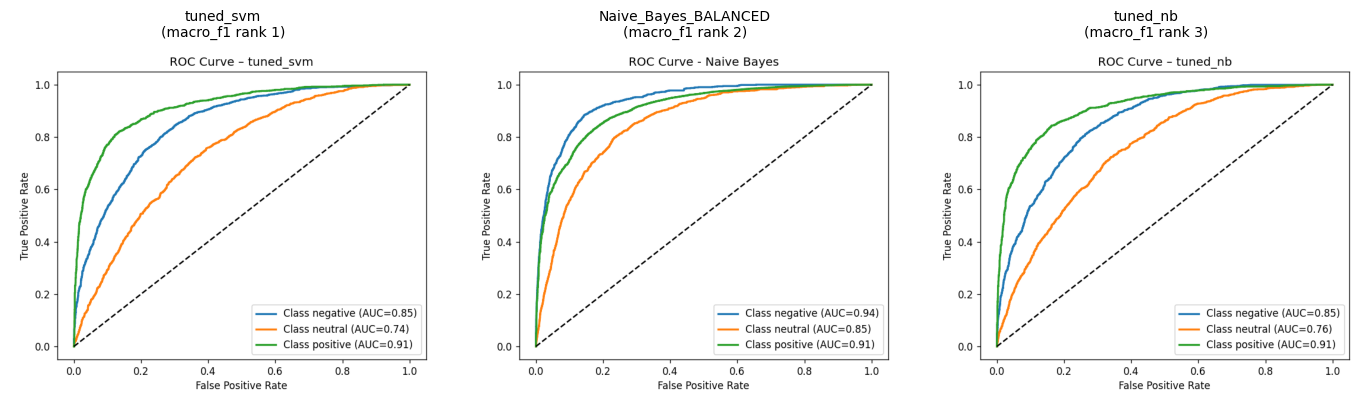

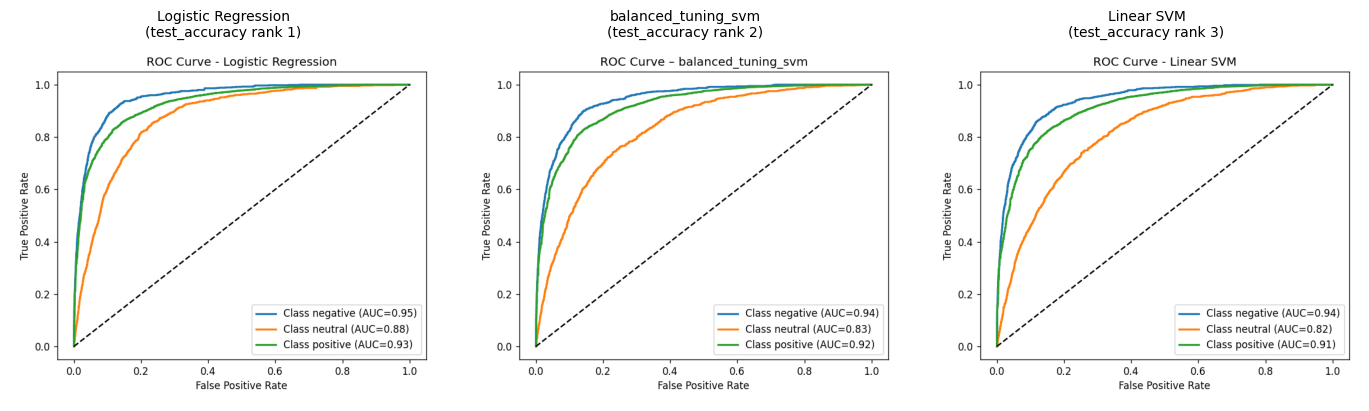

In [11]:
def find_model_folder(base_dir, model_name):
    """
    Try to locate a folder inside base_dir that best matches model_name,
    ignoring case and underscores.
    """
    norm_model = re.sub(r'[_\W]+', '', model_name).lower()
    for folder in os.listdir(base_dir):
        norm_folder = re.sub(r'[_\W]+', '', folder).lower()
        if norm_model in norm_folder or norm_folder in norm_model:
            return os.path.join(base_dir, folder)
    return None


def show_roc_curves(df, base_dir="results", sort_by="macro_f1", top_n=3):
    """
    Display ROC curve images for top models with flexible folder matching.
    """
    top_models = (
        df.sort_values(by=sort_by, ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    plt.figure(figsize=(14, 4))
    for i, model_name in enumerate(top_models["model"], 1):
        folder_path = find_model_folder(base_dir, model_name)
        roc_path = None
        if folder_path:
            possible_path = os.path.join(folder_path, "roc_curve.png")
            if os.path.exists(possible_path):
                roc_path = possible_path
        
        plt.subplot(1, top_n, i)
        if roc_path:
            img = mpimg.imread(roc_path)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{model_name}\n({sort_by} rank {i})", fontsize=10)
        else:
            plt.text(0.5, 0.5, "ROC not found", ha="center", va="center")
            plt.axis("off")
            plt.title(f"{model_name}\n({sort_by} rank {i})", fontsize=10)
    
    plt.tight_layout()
    plt.show()


# Example usage
show_roc_curves(df_results, base_dir="results", sort_by="macro_f1", top_n=3)
show_roc_curves(df_results, base_dir="results", sort_by="test_accuracy", top_n=3)

Notice that the classes with the best macro-f1 score had lower AUC scores across the board than the models with with higher test accuracy except for the Naive Bayes class that was balanced, however the test accuracy for these were about 66% while the high-test accuracy models had about 92% accuracy but macro f1-scores were ranging from about 59-54%. This aligns theoretically with class imbalances being dealt with because ROC-AUC is mostly class invariant to balance of classes because it relies on TPR and FPR which is just rates for true positive rate and false positive rate. 

It's possible that high accuracy models have dominantly predicted the majority class and this is why the macro f1-score is so important because it emphasizes the performance of the minority classes as these now have equal importance on dragging down the f1 score.

But the ROC-AUC is still important because it illustrates the sensitivity vs specificity trade-off per class, a steep rise in the y-axis of the class shows good separability, whereas the flatter curves might represent overlapping probability distributions between classes. Furthermore, the ROC-AUC graph may also show how tuning and balancing different models compares the difference between discrimination between classes, i.e., did it favour the discrimination of the positive class or the negative class? Looking at the graphs the Linear SVM had a higher AUC for negative class at 0.94, but the tuned_svm had a higher positive class at 0.91.

# Deep Learning Models

In [3]:
BASE_DIR = "outputs_colab"

records = []

# Walk through all subfolders in outputs_colab
for root, dirs, files in os.walk(BASE_DIR):
    for file in files:
        if file.endswith("_classification_report.json"):
            json_path = os.path.join(root, file)
            
            # Load JSON
            with open(json_path, "r") as f:
                data = json.load(f)

            # Extract model name from filename (e.g. "bert_lstm_gelu")
            model_name = file.replace("_classification_report.json", "")
            
            # Core metrics
            accuracy = data.get("accuracy")
            macro = data.get("macro avg", {})
            weighted = data.get("weighted avg", {})

            # Optional: extract per-class metrics (0,1,2)
            neg = data.get("0", {})
            neu = data.get("1", {})
            pos = data.get("2", {})

            records.append({
                "model": model_name,
                "accuracy": accuracy,
                "macro_precision": macro.get("precision"),
                "macro_recall": macro.get("recall"),
                "macro_f1": macro.get("f1-score"),
                "weighted_precision": weighted.get("precision"),
                "weighted_recall": weighted.get("recall"),
                "weighted_f1": weighted.get("f1-score"),
                "neg_f1": neg.get("f1-score"),
                "neu_f1": neu.get("f1-score"),
                "pos_f1": pos.get("f1-score")
            })

# Create DataFrame
df_dl_results = pd.DataFrame(records)

# Sort by macro-F1 descending
df_dl_results = df_dl_results.sort_values(by="macro_f1", ascending=False).reset_index(drop=True)

In [4]:
df_dl_results

,model,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1,neg_f1,neu_f1,pos_f1
0,roberta-gru-gelu,0.908304,0.649069,0.750009,0.682263,0.941789,0.908304,0.921907,0.682003,0.404218,0.960567
1,roberta_lstm_gelu,0.906310,0.645737,0.746251,0.678844,0.941223,0.906310,0.920607,0.689980,0.386900,0.959653
2,bert-gru-,0.909051,0.642906,0.738440,0.676572,0.939316,0.909051,0.921612,0.679547,0.389016,0.961154
3,bert-rnn-gelu,0.910733,0.635337,0.740238,0.675802,0.937240,0.910733,0.921805,0.686361,0.379512,0.961532
4,roberta-rnn-gelu,0.898025,0.644465,0.756420,0.675792,0.942862,0.898025,0.915824,0.682192,0.390613,0.954571
5,bert_lstm_gelu,0.902386,0.637984,0.738966,0.671293,0.938631,0.902386,0.917303,0.683578,0.373264,0.957038
6,roberta-cnn-gelu,0.894101,0.640310,0.743410,0.667160,0.941165,0.894101,0.912964,0.676859,0.371966,0.952655
7,roberta_bi_lstm_gelu,0.894911,0.630970,0.747597,0.667010,0.939306,0.894911,0.912830,0.680711,0.367779,0.952540
8,bert_bi_lstm_gelu,0.904255,0.627165,0.734332,0.666093,0.936568,0.904255,0.917676,0.671765,0.368228,0.958285
9,bert-cnn-gelu,0.907494,0.626338,0.731532,0.666079,0.936532,0.907494,0.919640,0.669182,0.368496,0.960557


In [5]:
# --- Top 3 based on Macro F1 ---
top3_macro_f1 = (
    df_dl_results.sort_values(by="macro_f1", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("Top 3 Models by Macro F1-score:")
print(top3_macro_f1[["model", "macro_f1", "accuracy"]])
print()

# --- Top 3 based on Accuracy ---
top3_accuracy = (
    df_dl_results.sort_values(by="accuracy", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print("Top 3 Models by Accuracy:")
print(top3_accuracy[["model", "accuracy", "macro_f1"]])


Top 3 Models by Macro F1-score:
               model  macro_f1  accuracy
0   roberta-gru-gelu  0.682263  0.908304
1  roberta_lstm_gelu  0.678844  0.906310
2          bert-gru-  0.676572  0.909051

Top 3 Models by Accuracy:
              model  accuracy  macro_f1
0     bert-rnn-gelu  0.910733  0.675802
1         bert-gru-  0.909051  0.676572
2  roberta-gru-gelu  0.908304  0.682263


As compared to the more basic machine learning models, the macro F1-score and accuracy are much more consistent for the deep learning models. We are now gettting slightly lower accuracy but much better macro-f1 scores with regards to maintaining accuracy. This means that the models are better discriminating the minority classes. 

This might also hint at better generalization and it definitely shows better minority class discrimination. Which might create a more fair model across class distributions

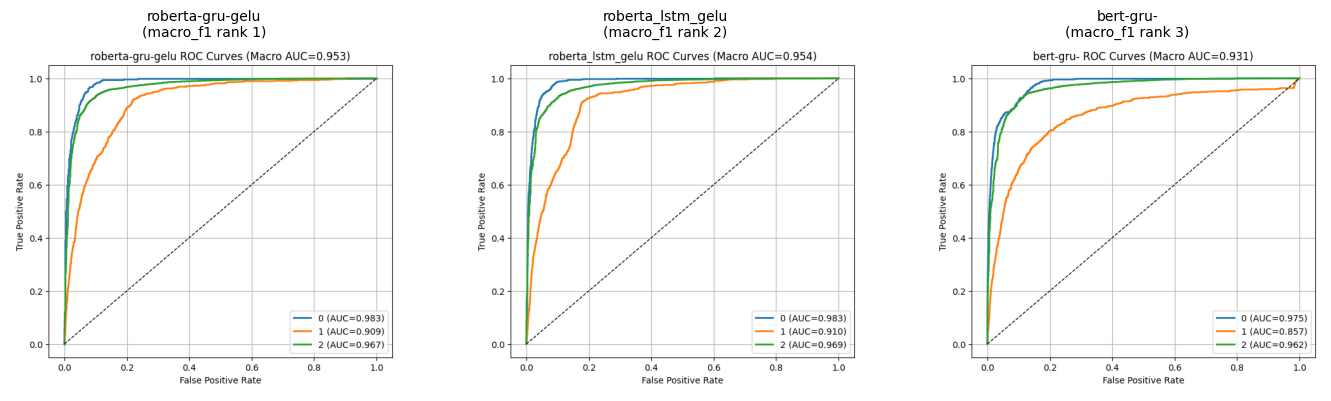

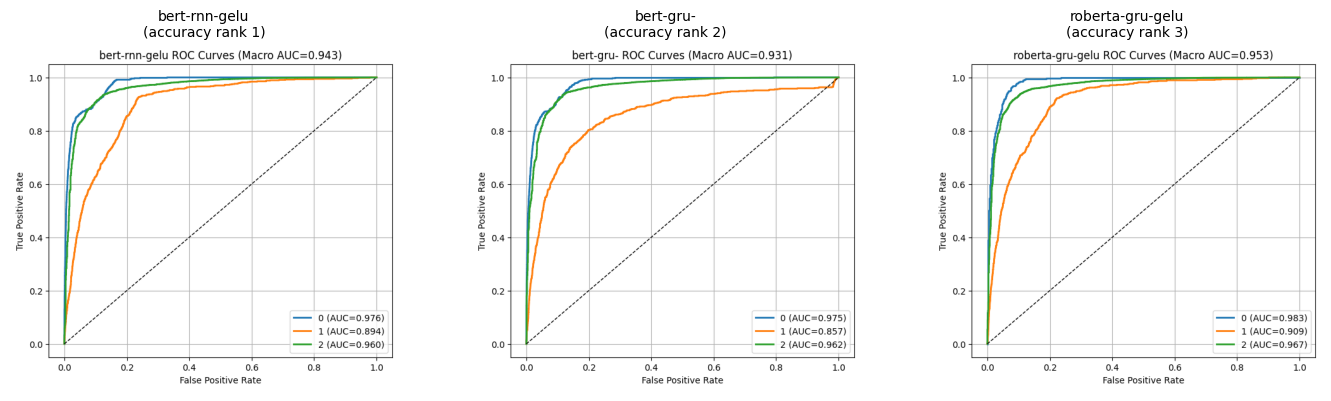

In [7]:
def find_model_image(base_dir, model_name):
    """
    Try to locate the ROC-AUC image file for a model (case-insensitive, underscore-insensitive).
    Matches filenames containing both the model name and 'roc_auc'.
    """
    norm_model = re.sub(r'[_\W]+', '', model_name).lower()
    for root, _, files in os.walk(base_dir):
        for f in files:
            norm_file = re.sub(r'[_\W]+', '', f).lower()
            if 'rocauc' in norm_file and norm_model in norm_file:
                return os.path.join(root, f)
    return None


def show_roc_curves(df, base_dir, sort_by="macro_f1", top_n=3):
    """
    Display ROC–AUC images for the top models based on a given metric.
    """
    top_models = (
        df.sort_values(by=sort_by, ascending=False)
        .head(top_n)
        .reset_index(drop=True)
    )

    plt.figure(figsize=(14, 4))
    for i, model_name in enumerate(top_models["model"], 1):
        img_path = find_model_image(base_dir, model_name)
        plt.subplot(1, top_n, i)
        if img_path and os.path.exists(img_path):
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{model_name}\n({sort_by} rank {i})", fontsize=10)
        else:
            plt.text(0.5, 0.5, "ROC image not found", ha="center", va="center")
            plt.axis("off")
            plt.title(f"{model_name}\n({sort_by} rank {i})", fontsize=10)

    plt.tight_layout()
    plt.show()


# --- Plot ROC curves for top 3 by macro-F1 ---
show_roc_curves(df_dl_results, base_dir=BASE_DIR, sort_by="macro_f1", top_n=3)

# --- Plot ROC curves for top 3 by accuracy ---
show_roc_curves(df_dl_results, base_dir=BASE_DIR, sort_by="accuracy", top_n=3)

In addition to the stronger macro-F1 performance, the deep learning models also demonstrate markedly higher AUC-ROC values across all classes. This indicates that these models achieve better overall separability between positive and negative decision boundaries at every possible classification threshold. The smoother and steeper ROC curves suggest that the learned feature representations, particularly through transformer-based embeddings combined with recurrent layers-enable the models to capture more nuanced contextual relationships in the text. Consequently, they can more confidently distinguish between sentiment classes, achieving both higher discriminative power and more stable behaviour across thresholds compared to the baseline machine-learning models.

Why might the ROC-AUC graphs be important here? This is important because the model threhsolds could be adjusted to capture more negatives without decreasing the precision of the model too much. However, the neutral class seems to be failing quite a bit, this isn't too concerning because neutral reviews tend to convey less semantic meaning and tend to not be as informative as a polarized review, however it is still possible to gain some information from neutral reviews. 

In the context of changing educational paedagogy it might be important to note that the separability of the negative class might be more important because we might want to actually prioritize the classification of the negative class because this identifies pain points of students/staff members regarding modules/subjects or processes. This is actionable insight in which thew institution can then make changes towards rectifying.

Timings for training inference 100k rows on l4 gpu {'total_time_sec': 335.12440299987793, 'time_per_sample_sec': 0.0031314769758347, 'time_per_batch_sec': 0.4003875782555292} at 1.71 compute units p/hr